In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import os
from matplotlib_venn import venn2


In [3]:
# marker_df = pd.read_csv('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')
marker_df = pd.read_csv(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/ACT_annotation/Human_blood_marker_processed.csv')
print(marker_df.shape)
marker_df.head()

(147, 6)


,Species,Tissue,super_type,CellType,Marker,Resource
0,Human,Blood,B,Activated B cell,"CD5, MIR155HG, TAGLN2","35025971, 28910360, 2474446"
1,Human,Blood,T_CD4,"Activated CD4-positive, alpha-beta T cell","CD4, CCR6, CD14, CD19, CD38, CD3D, CD3G, CD69,...","35381424, 32783921, 35831277, 34529726, 103413..."
2,Human,Blood,T_CD4,"Activated CD4-positive, CD25-positive, CCR4-po...","CD3D, CD3E, CD3G, CD4, FOXP3",30977974
3,Human,Blood,NaN,Adult endothelial progenitor cell,"KDR, PROM1, CD34, PTPRC, PECAM1, CD14","27561827, 29391882, 24641802, 29147957, 267700..."
4,Human,Blood,T,Alpha-beta T cell,"CD3D, CD3E, CD3G, IL7R","34284174, 28777444"


## Read PreLect features

In [10]:
types = ['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']

In [ ]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_batch_noZ/Level2/large_lambda/features')
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level2/large_lambda/features')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df_k3 = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df_k3
    except:
        print('skipping:', celltype)
        continue

count_df_k3 = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df_k3 = features_dict[celltype]
    feature_count = feature_df_k3.shape[0]
    positive_count = feature_df_k3[feature_df_k3['Tendency'] == 1].shape[0]
    count_df_k3.loc[celltype] = [feature_count, positive_count]
count_df_k3

In [12]:
# Do two comparisons:
#   1. All_PreLect vs. Marker in database
#   2. Positive_PreLect vs. Marker in database
def compare_PreLect_w_marker(celltype, PreLect_dict, marker_genes, name=''):
    if name == '':
        name = celltype
    # Extracting the features and marker genes
    feature_df = PreLect_dict[celltype]
    features = feature_df['Gene'].tolist()
    positve_features = feature_df[feature_df['Tendency'] == 1]['Gene'].tolist()
    # marker_genes = marker_df['official gene symbol'].tolist()

    ### All features
    # Finding common elements
    common_all = list(set(features) & set(marker_genes))
    print(celltype, 'All features common with markers:', len(common_all))
    # Preparing sets for Venn diagram
    features_set = set(features)
    marker_genes_set = set(marker_genes)
    # Plotting Venn diagram
    plt.figure(figsize=(8, 5))
    v = venn2([features_set, marker_genes_set], set_labels=('PreLect all', f'{name} Marker'))
    plt.title(name, fontsize=16)
    for text in v.set_labels:
        text.set_fontsize(14)
    for text in v.subset_labels:
        text.set_fontsize(16)
    plt.show()

    ### Positive features
    # Finding common elements
    common_positive = list(set(positve_features) & set(marker_genes))
    print(celltype, 'Positive features common with markers:', len(common_positive))
    # Preparing sets for Venn diagram
    positive_features_set = set(positve_features)
    marker_genes_set = set(marker_genes)
    # Plotting Venn diagram
    plt.figure(figsize=(8, 5))
    v = venn2([positive_features_set, marker_genes_set], set_labels=('PreLect positive', f'{name} Marker'), set_colors=('blue', 'green'))
    plt.title(name, fontsize=16)
    for text in v.set_labels:
        text.set_fontsize(14)
    for text in v.subset_labels:
        text.set_fontsize(16)
    plt.show()

    return common_all, common_positive


In [13]:
def get_celltype_marker(name, marker_df):
    string = marker_df[marker_df['CellType'] == name]['Marker'].tolist()[0]
    marker_list = string.split(', ')
    return marker_list

## Function for running comparison

In [14]:
def run_compare(clus_name, act_name, features_dict, marker_df, marker_list=None):
    if marker_list:
        common, common_p = compare_PreLect_w_marker(clus_name, features_dict, marker_list, name=clus_name)
    else:
        common, common_p = compare_PreLect_w_marker(clus_name, features_dict, get_celltype_marker(act_name, marker_df), name=clus_name)
    print(f'{clus_name}_common:', common)
    print(f'{clus_name}_common_p:', common_p)

In [15]:
clus_name_pairs = [
    ('B_memory', 'Memory B cell'),
    ('B_naive', 'Naive B cell'),
    ('CD14_Mono', 'Classical monocyte'),
    ('CD16_Mono', 'Non-classical monocyte'),
    ('CD4_Proliferating', 'Proliferating CD4-positive, alpha-beta T cell'),
    ('CD4_TCM', 'Central memory CD4-positive, alpha-beta T cell'),
    ('CD4_TEM', 'Effector memory CD4-positive, alpha-beta T cell'),
    ('CD8_Naive', 'Naive thymus-derived CD8-positive, alpha-beta T cell'),
    ('CD8_TEM', 'Effector memory CD8-positive, alpha-beta T cell'),
    ('cDC1', 'Type 1 conventional dendritic cell'),
    ('cDC2', 'Type 2 conventional dendritic cell'),
    ('gdT', 'Gamma-delta T cell'),
    ('HSPC', 'Hematopoietic stem cell'),
    ('MAIT', 'Mucosal invariant T cell'),
    ('pDC', 'Plasmacytoid dendritic cell'),
    ('Treg', 'Regulatory T cell'),
    ('CD4_CTL', 'CD4-positive, alpha-beta cytotoxic T cell'),
    ('CD4_Naive', 'Naive thymus-derived CD4-positive, alpha-beta T cell'),
    ('CD8_TCM', 'Central memory CD8-positive, alpha-beta T cell'),
    ('Plasmablast', 'Plasmablast')
]
cluster_2_act_name = dict(clus_name_pairs)
cluster_2_act_name

{'B_memory': 'Memory B cell',
 'B_naive': 'Naive B cell',
 'CD14_Mono': 'Classical monocyte',
 'CD16_Mono': 'Non-classical monocyte',
 'CD4_Proliferating': 'Proliferating CD4-positive, alpha-beta T cell',
 'CD4_TCM': 'Central memory CD4-positive, alpha-beta T cell',
 'CD4_TEM': 'Effector memory CD4-positive, alpha-beta T cell',
 'CD8_Naive': 'Naive thymus-derived CD8-positive, alpha-beta T cell',
 'CD8_TEM': 'Effector memory CD8-positive, alpha-beta T cell',
 'cDC1': 'Type 1 conventional dendritic cell',
 'cDC2': 'Type 2 conventional dendritic cell',
 'gdT': 'Gamma-delta T cell',
 'HSPC': 'Hematopoietic stem cell',
 'MAIT': 'Mucosal invariant T cell',
 'pDC': 'Plasmacytoid dendritic cell',
 'Treg': 'Regulatory T cell',
 'CD4_CTL': 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4_Naive': 'Naive thymus-derived CD4-positive, alpha-beta T cell',
 'CD8_TCM': 'Central memory CD8-positive, alpha-beta T cell',
 'Plasmablast': 'Plasmablast'}

## Cell types with fewer features at large lambda

In [17]:
features_dict.keys()

dict_keys(['ASDC', 'B_intermediate', 'B_memory', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'ILC', 'MAIT', 'NK_CD56bright', 'NK_Proliferating', 'Treg', 'dnT'])

Skipping ASDC
Skipping B_intermediate
B_memory All features common with markers: 3


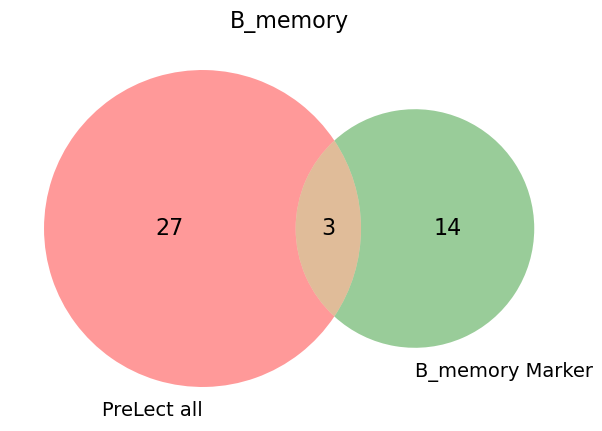

B_memory Positive features common with markers: 2


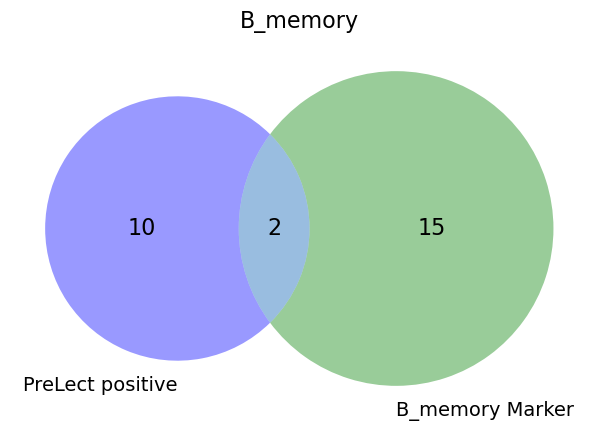

B_memory_common: ['IGHM', 'AIM2', 'MS4A1']
B_memory_common_p: ['AIM2', 'MS4A1']
CD4_CTL All features common with markers: 3


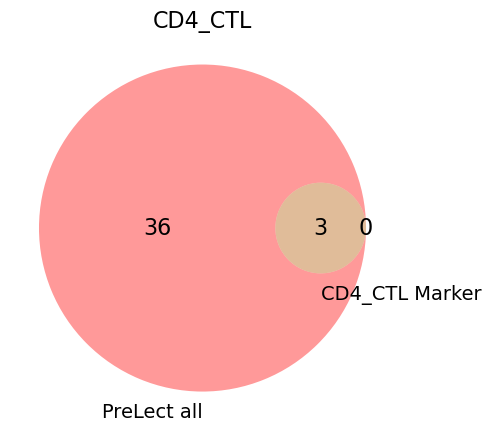

CD4_CTL Positive features common with markers: 3


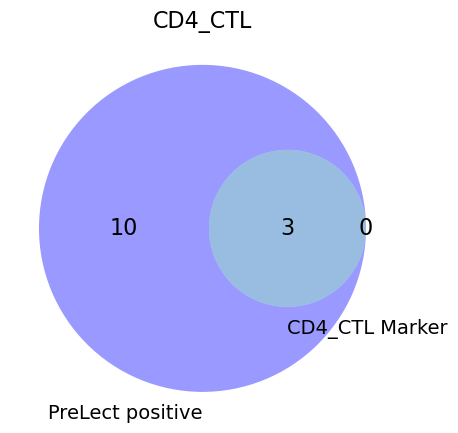

CD4_CTL_common: ['GNLY', 'GZMH', 'NKG7']
CD4_CTL_common_p: ['GNLY', 'GZMH', 'NKG7']
CD4_Naive All features common with markers: 3


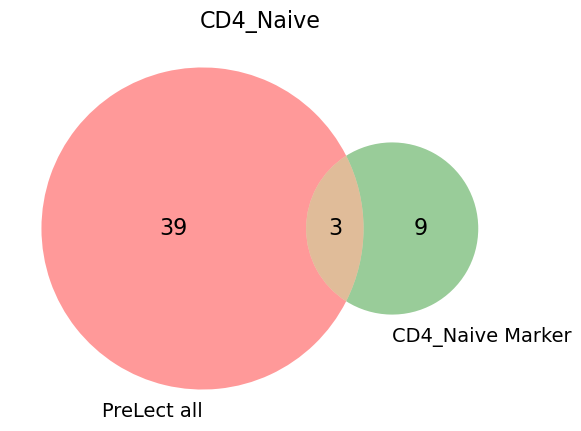

CD4_Naive Positive features common with markers: 3


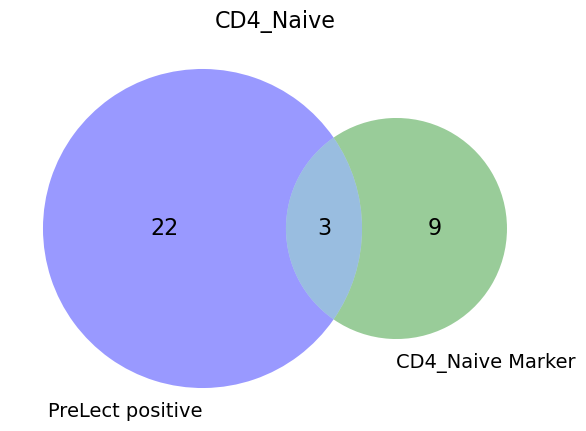

CD4_Naive_common: ['LEF1', 'TCF7', 'CCR7']
CD4_Naive_common_p: ['LEF1', 'TCF7', 'CCR7']
CD4_Proliferating All features common with markers: 3


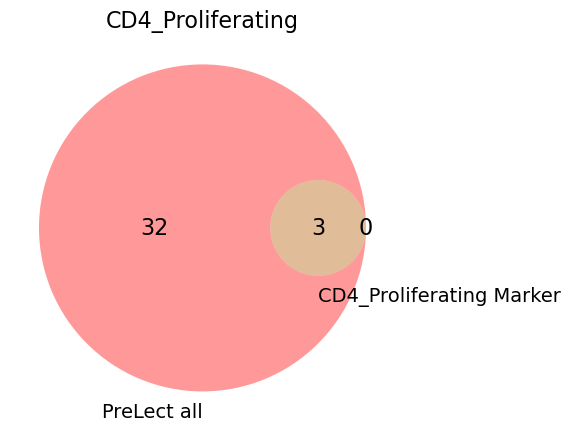

CD4_Proliferating Positive features common with markers: 3


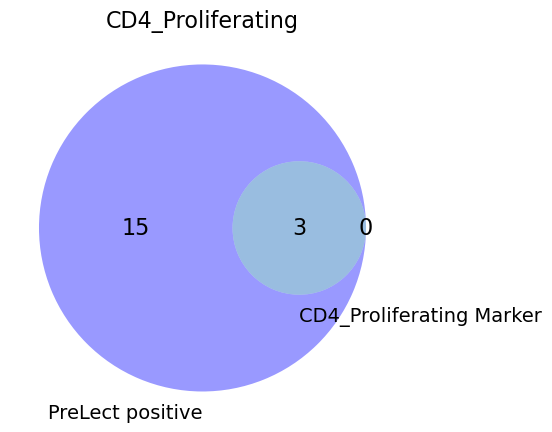

CD4_Proliferating_common: ['STMN1', 'TUBA1B', 'MKI67']
CD4_Proliferating_common_p: ['STMN1', 'TUBA1B', 'MKI67']
CD4_TCM All features common with markers: 9


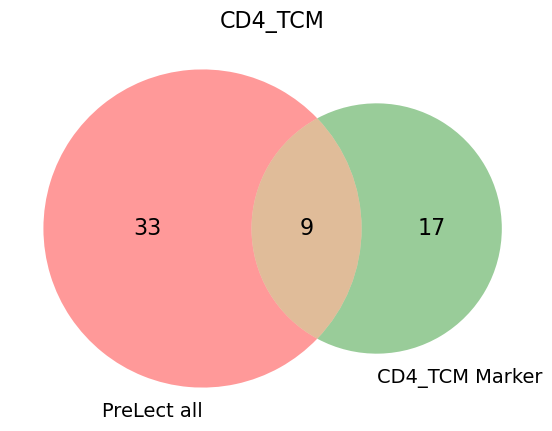

CD4_TCM Positive features common with markers: 9


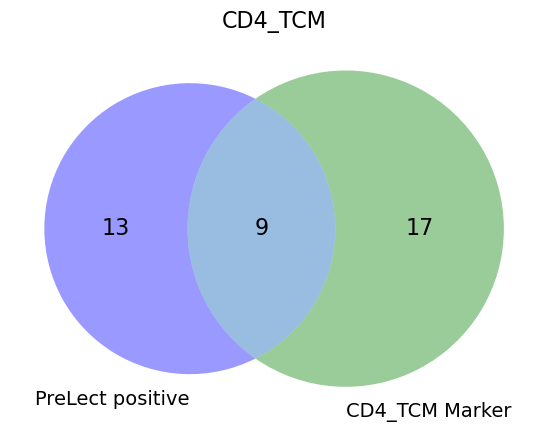

CD4_TCM_common: ['ANXA1', 'ITGB1', 'IL32', 'LDHB', 'LTB', 'AQP3', 'TRAC', 'CD69', 'IL7R']
CD4_TCM_common_p: ['ANXA1', 'ITGB1', 'IL32', 'LDHB', 'LTB', 'AQP3', 'TRAC', 'CD69', 'IL7R']
CD4_TEM All features common with markers: 5


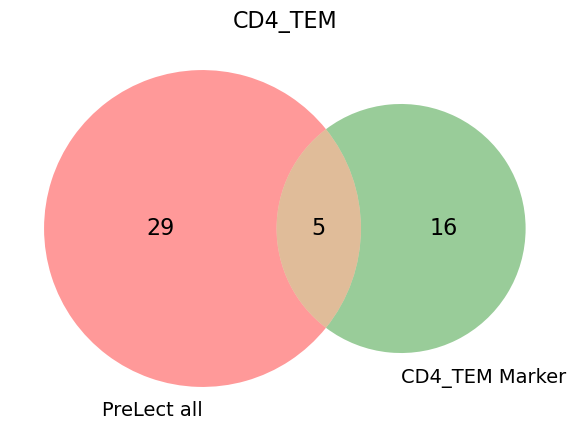

CD4_TEM Positive features common with markers: 4


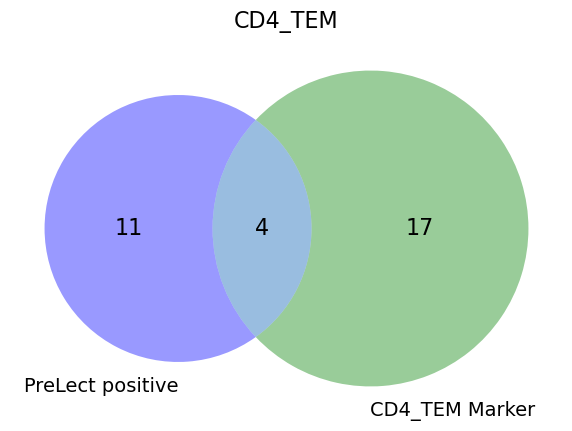

CD4_TEM_common: ['ITGB1', 'IL7R', 'CCL5', 'KLRB1', 'GZMK']
CD4_TEM_common_p: ['CCL5', 'KLRB1', 'GZMK', 'IL7R']
CD8_Naive All features common with markers: 4


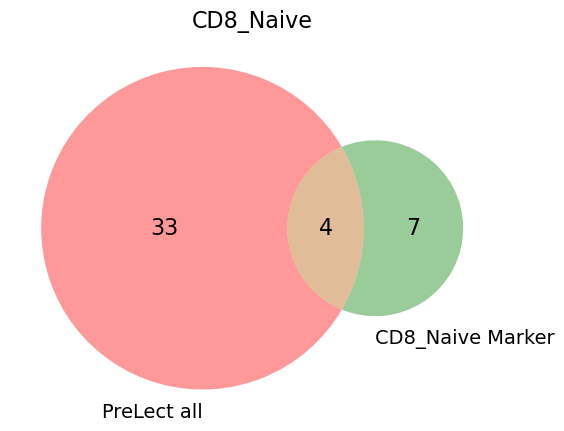

CD8_Naive Positive features common with markers: 4


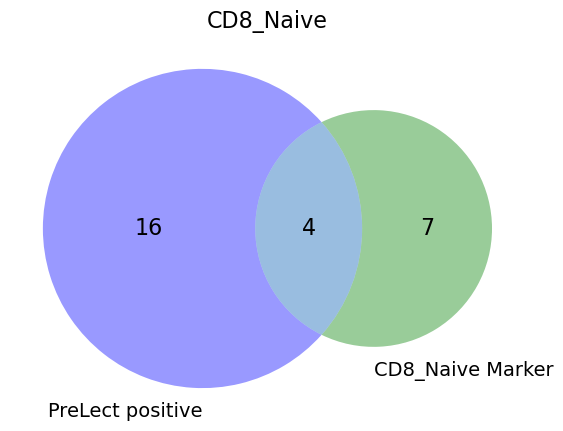

CD8_Naive_common: ['CD8B', 'CD8A', 'LEF1', 'CCR7']
CD8_Naive_common_p: ['CD8B', 'CD8A', 'LEF1', 'CCR7']
Skipping CD8_Proliferating
CD8_TCM All features common with markers: 3


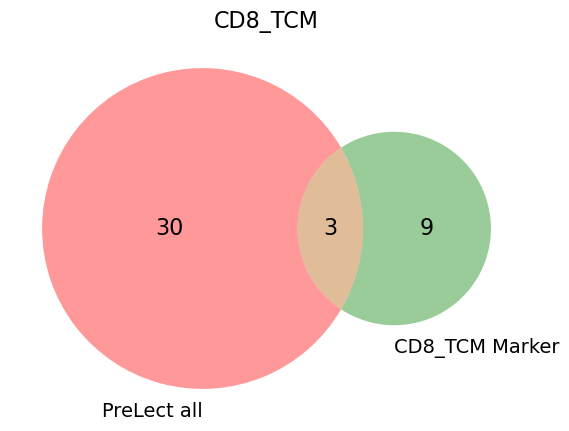

CD8_TCM Positive features common with markers: 3


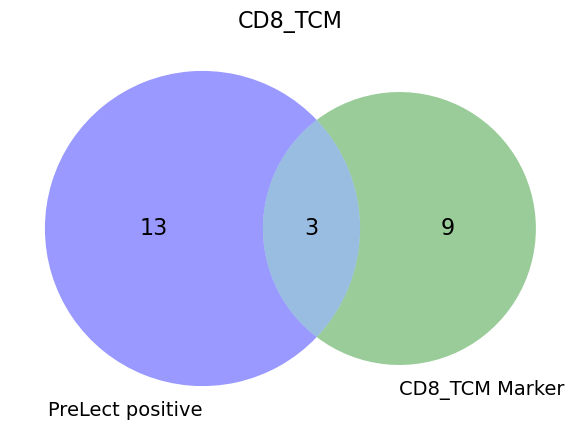

CD8_TCM_common: ['CD8B', 'CD8A', 'IL7R']
CD8_TCM_common_p: ['CD8B', 'CD8A', 'IL7R']
CD8_TEM All features common with markers: 11


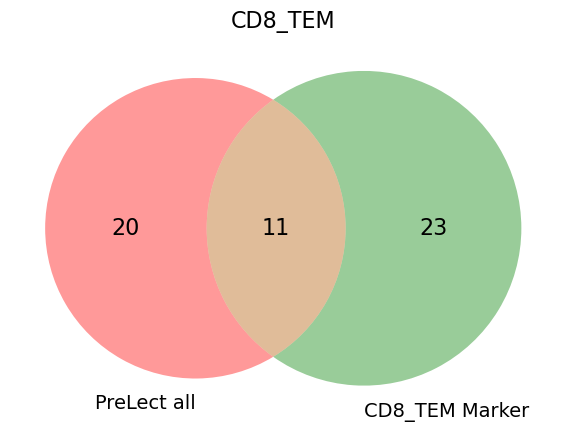

CD8_TEM Positive features common with markers: 10


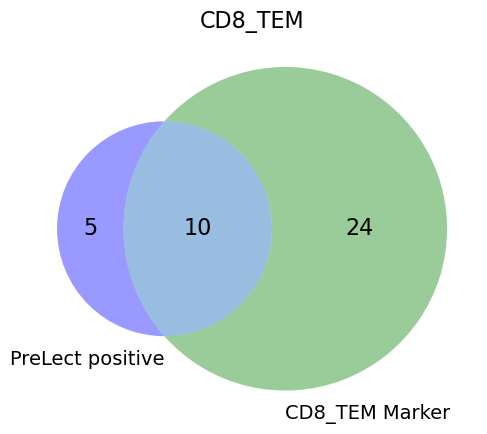

CD8_TEM_common: ['CD3D', 'KLRD1', 'CD8B', 'TRGC2', 'CST7', 'CD8A', 'TRAC', 'NKG7', 'CD3G', 'PRF1', 'CCL5']
CD8_TEM_common_p: ['CD3D', 'KLRD1', 'CD8B', 'TRGC2', 'CST7', 'CD8A', 'TRAC', 'NKG7', 'CD3G', 'CCL5']
Skipping ILC
MAIT All features common with markers: 4


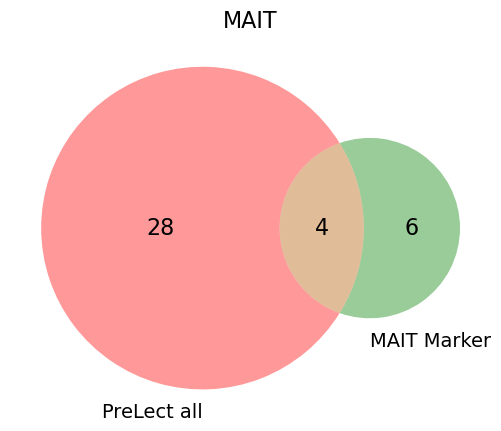

MAIT Positive features common with markers: 4


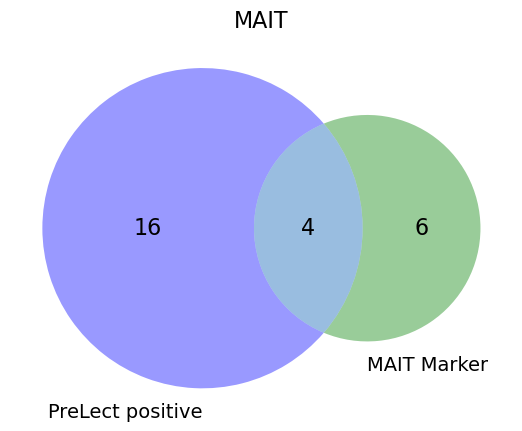

MAIT_common: ['SLC4A10', 'CD8A', 'CXCR4', 'KLRB1']
MAIT_common_p: ['SLC4A10', 'CD8A', 'CXCR4', 'KLRB1']
Skipping NK_CD56bright
Skipping NK_Proliferating
Treg All features common with markers: 2


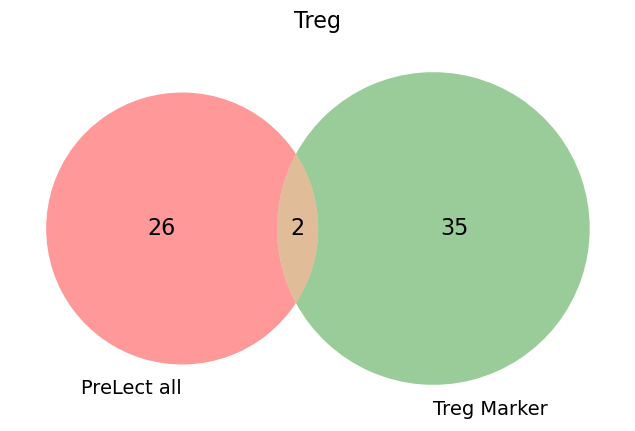

Treg Positive features common with markers: 1


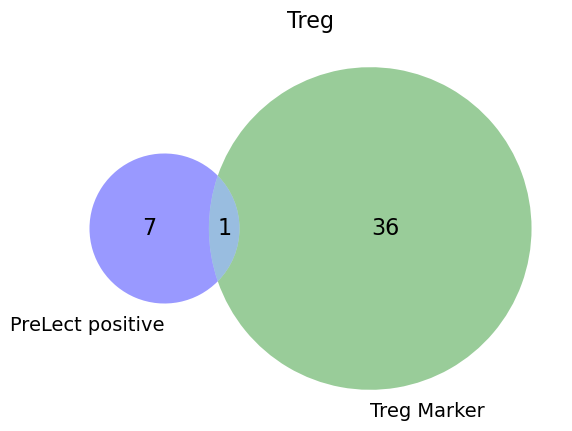

Treg_common: ['RTKN2', 'IL7R']
Treg_common_p: ['RTKN2']
Skipping dnT


In [19]:
for celltype in features_dict.keys():
    if celltype not in cluster_2_act_name.keys():
        print('Skipping', celltype)
        continue
    run_compare(celltype, cluster_2_act_name[celltype], features_dict, marker_df)